## Logical modeling of neuroectoderm specification in fruit flies

Egfr signaling is one of the signaling networks regulating fruit fly neuroectoderm development. Given the complexity of signaling networks as well as the amount of information to be integrated, a logical model of Egfr signaling will provide a better understanding of how developmental signals combine to control cellular states.


This project implements CoLoMoTo Interactive Notebook to provide a reprodicible and executable analyses. The workflow used as follows:

(1) the importation of a GINsim model and its display, (2) its format conversion using the Java library BioLQM, (3) the formal prediction of mutations using the OCaml software Pint, (4) the model checking using the C++ software NuSMV, (5) quantitative stochastic simulations using the C++ software MaBoSS, and (6) the visualisation of results using the Python library matplotlib. 

### Visualization of Egfr pathway with GINsim

In [136]:
# Set up working environment for CoLoMoTo
%matplotlib inline
import numpy as np
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import DataFrame
import seaborn as sns
import re
import pprint
from collections import Counter
#import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Tools necessary to run and perturb the model
import ginsim 
import biolqm
import pypint
import maboss

# Tools necessary to format and plot results of simulations
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
import pandas as pd # for the visualization of lists of states


## Import model from github repository

Logical model of Egfr signaling can be directly loaded from my github repository at https://github.com/ozlembahar/DevelopmentalSignaling/blob/master/Ginsim/Egfr-core-(p)Gro.zginml.

In [141]:
#Load the model
lrg_ppt = pypint.load("markers.zginml")
info_lrg = lrg_ppt.summary()
pd.DataFrame([['nb_states',info_lrg['nb_states']],['nb_automata',info_lrg['nb_automata']],['nb_transitions',info_lrg['nb_transitions']]], columns=['Item','Number'])

lrg = ginsim.load("markers.zginml")
lqm2 = ginsim.to_biolqm(lrg)

# Display the regulatory graph as specified in the model file
ginsim.show(lrg)

In [138]:
# Compute the total number of stable states
fps = biolqm.fixpoints(lqm2)
print(len(fps), "fixpoints found")

16 fixpoints found


In [144]:
# Find the wild-type stable state
fps_pd = pd.DataFrame(fps)
fps_pd = fps_pd.iloc[:,0:2]
fps_pd["input_list"] = fps_pd['Hh'].astype(str) + fps_pd['Wg'].astype(str) + fps_pd['Egfr'].astype(str)


v_index = fps_pd[fps_pd["input_list"] == "001"].index.values
c_index = fps_pd[fps_pd["input_list"] == "110"].index.values
d_index = fps_pd[fps_pd["input_list"] == "111"].index.values

# Ventral stable state
ginsim.show(lrg, fps[c_index[0]])

KeyError: 'Wg'

In this regulatory graph, green arrows and red T arrows respectively denote activatory and inhibitory interactions. A set of rules combining the vertices with the Boolean operators NOT, AND, and OR, which must be consistent with the regulatory graph, then allows the computation of enabled transitions for each network state.

## Boolean functions of the Egfr pathway


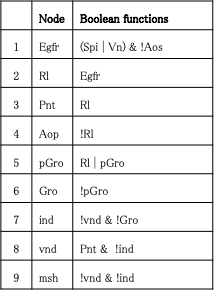


Boolean functions of the each of the 12 components summarized in a table.

## Helper functions

Some helper functions and color mapping rules to perform value propagation and visualize the result.

In [119]:
# Function 1 : dash_pattern
# Transforms a dictionary into a dash-like pattern used for space restrictions.
# If a model has 4 components A, B, C, D in this order,
#  {A:0, D:1} => "0--1"
def dash_pattern(model, dict_vals):
    specific_comps = dict_vals.keys()
    str_pattern = ""
    for comp in model.getComponents():
        if comp.toString() in specific_comps:
            str_pattern += str(dict_vals.get(comp.toString()))
        else :
            str_pattern += "-"
    return(str_pattern)


# Function 2 : getPert (from Swann)
# Integrate perturbation information with initial state.
# As initial state do not allow initial state for a multilevel node at level 2, we define Nodal as a perturbation
def getPert(rest_list, nodal_list, pert_list) :
    new_rest = {}
    # Adapt the initial state of perturbed node (sets it to its perturbation level)
    for k in rest_list.keys() :
        if k not in pert_list.keys() :
            new_rest[k] = rest_list[k]
        elif k in pert_list.keys() :
            new_rest[k] = pert_list[k]
    new_pert = ""
    # Format the perturbation in the node%level style, add Nodal_In if its not alreay present
    for k in pert_list.keys() :
        new_pert += " " + k + "%" + str(pert_list[k])
    if "Hh" not in pert_list.keys() :
        new_pert += " Hh%" + str(nodal_list["Hh"])
    if "Wg" not in pert_list.keys() :
        new_pert += " Wg%" + str(nodal_list["Wg"])
    if "Egfr" not in pert_list.keys() :
        new_pert += " Egfr%" + str(nodal_list["Egfr"])
    return(new_rest, new_pert)


# Function 3 : getFxp (from Swann)
# Format the resulting output from fixpoints search.
# In case of multiple possible fixpoints, we store them as new individual keys in a dictionnary. Order is random
def getFxp(fixpoints) :
    fxp_formated = {}
    for territory in fixpoints.keys() :
        if len(fixpoints[territory]) == 1 :
            fxp_formated[territory] = [fixpoints[territory][0]]
        elif len(fixpoints[territory]) == 0 :
            fxp_formated[territory] = []
        elif len(fixpoints[territory]) > 1 :
            fxp_formated[territory] = fixpoints[territory]
    return(fxp_formated)


# Function 3 : getFxp (from Swann)
# Format the resulting output from fixpoints search.
# In case of multiple possible fixpoints, we store them as new individual keys in a dictionnary. Order is random
def getFxp(fixpoints) :
    fxp_formated = {}
    for territory in fixpoints.keys() :
        if len(fixpoints[territory]) == 1 :
            fxp_formated[territory] = [fixpoints[territory][0]]
        elif len(fixpoints[territory]) == 0 :
            fxp_formated[territory] = []
        elif len(fixpoints[territory]) > 1 :
            fxp_formated[territory] = fixpoints[territory]
    return(fxp_formated)

# Function 4 : split_multiSS (from Swann)
# In case where we find more than one stable state in one of the territory, we create one instance of
# simulation result for each different stable state reached
def split_multiSS(fxp_res, pert_name) :
    num_ss_max = max(len(fxp_res[ter]) for ter in fxp_res.keys())
    out_dict = {}
    if num_ss_max > 1 :
        for step in range(0,num_ss_max) :
            out_dict[pert_name + '_ss' + str(step)] = {}
            for ter in fxp_res.keys() :
                if len(fxp_res[ter])-1 < step :
                    item = len(fxp_res[ter])-1
                elif len(fxp_res[ter])-1 >= step : 
                    item = step
                out_dict[pert_name + '_ss' + str(step)][ter] = fxp_res[ter][item]
    elif num_ss_max == 1 :
        out_dict[pert_name] = {}
        for ter in fxp_res.keys() :
            out_dict[pert_name][ter] = fxp_res[ter][0]
    return(out_dict)

In [120]:
# Wild-type simulation

## Define the wild type initial state conditions for the inputs in the three territories
# Univin is also fixed at 1 to avoid simulating events where Univin level reaches 0
inputs_state = { "DV" : {"Hh":0, "Wg":0 , "Egfr":1} , 
                 "AP" : {"Hh":1, "Wg":1 , "Egfr":0} ,
                 "DV_AP" : {"Hh":1, "Wg":1 , "Egfr":1}}
core_vals = {}

# Define the wild type initial state conditions for Nodal input() in the three territories
nodal_state =  { "DV" : {"Hh":0, "Wg":1 , "Egfr":0}, 
                 "AP" : {"Hh":0, "Wg":1 , "Egfr":1},
                "DV_AP" : {"Hh":1, "Wg":1 , "Egfr":1}}

In [121]:
# Merge dict for figure
                
import copy
                
fig_inputs = copy.deepcopy(inputs_state)
for mykey in fig_inputs.keys() :
    fig_inputs[mykey].update(nodal_state[mykey])
pd.DataFrame(fig_inputs).T

,Hh,Wg,Egfr
DV,0,1,0
AP,0,1,1
DV_AP,1,1,1


In [126]:
# Using the function and the initial state condition,
# we compute fixpoints of the model for the three wild type territories
fixpoints = {}
for territory in inputs_state.keys() :
    # Generate the pattern and perturbation to apply
    ter_rest, ter_pert = getPert(inputs_state[territory],  nodal_state[territory], {})
    pattern = dash_pattern(lqm2, {**ter_rest, **core_vals})
    # Apply pattern and perturbation to the model
    model_mod = biolqm.perturbation(biolqm.restrict(lqm2, pattern), ter_pert)
    # Compute fixpoints and store it in a dictionnary
    fixpoints[territory] = biolqm.fixpoints(model_mod)    
    print("Finding", len(fixpoints[territory]),"stable state(s) for", territory, 'territory.')


Finding 2 stable state(s) for DV territory.
Finding 2 stable state(s) for AP territory.
Finding 2 stable state(s) for DV_AP territory.


In [127]:

# We apply the function to our wild type simulation and use it to plot the expression level of all nodes.
wild_type = getFxp(fixpoints)
wild_type = split_multiSS(wild_type, 'Wild_type')['Wild_type']
wt_fxp  = pd.DataFrame(wild_type)
plt.figure(figsize=(15, 6))
sns.clustermap(wt_fxp.dropna(0),  metric='euclidean', col_cluster=False, yticklabels=True, cmap='YlOrRd')

KeyError: 'Wild_type'

## Identification of stable states

Here we compute the complete list of logical stable states (or fixpoints) of the model using the Java library bioLQM and store it in the `fps` variable:

In [ ]:
fps = biolqm.fixpoints(lqm_model)
print(len(fps), "fixpoints found.")

In [ ]:
#Display of the list of stable states
tabulate(fps)

The model has 16 stable states, 3 of which represent the behavior of Egfr components specifying vnd domain(columns 6, 12, 13). While 8 of which represent the possible stable states for ind domain to generate, the remaining 5 rows corresponds to msh domain.

In [ ]:
#The third fixpoint (`fps[2]`) can then be displayed as follows:
ginsim.show(gs_model, fps[2])

In this graph, the vertices shown in white or blue denote components that are OFF (value 0) or ON (value 1) respectively.

## Identification of trap spaces

A trap space is a subspace of a state space which trajectories cannot leave. Trap spaces provide useful approaximations of attraction basin. Every trap space contains at least one attractor and, therefore, in some cases minimal trap spaces can be good approximations for the attractors. If a trap set is an attractor, its spaces of attraction can be related to its basins of attraction. Attractor reachability can be investigated using trap spaces.

In [ ]:
trapspaces = biolqm.trapspaces(lqm_model)
tabulate(trapspaces)

In [ ]:
 ginsim.show(lrg, trapspaces[1])

## Model simplification (skipped)

In [ ]:
## Model simplification (havent used): 
#   * Fix all inputs to their inactive state.
fixed = { str(n):0 for n in lqm_model.getComponents() if n.isInput()}

# Keep 'Spi', 'Hh' and as proper inputs 
for n in ('Spi', 'Hh', 'Wg'):
    del(fixed[n])

# Fix inputs to their active state
fixed['Spi'] = 1
fixed['Hh'] = 1
fixed['Wg'] = 1

In [ ]:
# Apply the simplifications defined above to reduce the model
m_reduced = biolqm.perturbation(lqm_model, " ".join([ "%s%%%s" % (k,v) for (k,v) in fixed.items() ]))
m_reduced = biolqm.reduce(m_reduced, ":fixed :purge :no-extra")

In [ ]:
fps = biolqm.fixpoints(m_reduced, autoconvert=False)
df = biolqm.states_to_dataframe(fps)
df

## Simulation of the model without any constraint

Fixed values are visualized on the model without any constraint. Fixed values will appear in white. This will be used as a reference to see if percolating a value will change anything from this default setting.

In [ ]:
# Reduce fixed values
lqm_model_fixed_reduced = biolqm.reduce(lqm_model, ":fixed :purge")
show_fixed(gs_model, lqm_model_fixed_reduced, styler_fixed)

## Perturbations via bioLQM 

In [ ]:
#Set ind to 1
mlqm = biolqm.perturbation(lqm_model, "ind%1")

fixpoints_ind = biolqm.fixpoints(mlqm)
tabulate(fixpoints_ind)

reduced = biolqm.reduce(mlqm , "fixed,outputs")


In [ ]:
#Set ind to 0
mlqm_ind_0 = biolqm.perturbation(lqm_model, "ind%0")

fixpoints_ind_0 = biolqm.fixpoints(mlqm_ind_0)

reduced_ind_0 = biolqm.reduce(mlqm_ind_0 , "fixed,outputs")
show_fixed(gs_model, reduced_ind_0 , styler_fixed)

In [ ]:
fixpoints_ind_0 = {'Spi': 0,
  'Egfr': 0,
  'Rl': 0,
  'Aop': 1,
  'Pnt': 0,
  'ind': 0,
  'vnd': 0,
  'msh': 1,
  'Aos': 0,
  'pGro': 0,
  'Gro': 1},
 
                  
fixpoints_ind_1 = {'Spi': 0,
  'Vn': 0,
  'Egfr': 0,
  'Rl': 0,
  'Aop': 1,
  'Pnt': 0,
  'ind': 1,
  'vnd': 0,
  'msh': 0,
  'Aos': 0,
  'pGro': 0,
  'Gro': 1}

# Display the model
ginsim.show(gs_model, fixpoints_ind_1)

## Display fixed points

In [ ]:
print("Before restriction : Total components : %d, Extra components : %d" % (len(lqm_model.getComponents()),
                                                        len(lqm_model.getExtraComponents())))
print("After restriction : Total components : %d, Extra components : %d" % (len(lqm_model_restricted_Spi_1.getComponents()),
                                                        len(lqm_model_restricted_Spi_1.getExtraComponents())))
#biolqm.fixpoints(lqm_model_restricted_Spi_1, "extra")

In [ ]:
# Percolate a value of 0 for vnd
lqm_model_restricted_vnd_0 = restrict_model(lqm_model, vnd=0)
show_fixed(gs_model, lqm_model_restricted_vnd_0, styler_fixed)

In [ ]:
# Percolate a value of 1 for vnd
lqm_model_restricted_vnd_1 = restrict_model(lqm_model, vnd=1)
show_fixed(gs_model, lqm_model_restricted_vnd_1, styler_fixed, save="figure_percolation_vnd_1")

In [ ]:
show_fixed_comparison(gs_model, lqm_model_restricted_vnd_0, lqm_model_restricted_vnd_1, styler_comp, save="figure_percolation_vnd")

## Assessing the probabilities to reach alternative attractors using MaBoSS

MaBoSS (Stoll et al., 2017) is a C++ software enabling the stochastic simulation of Boolean networks by translating them into continuous time Markov processes. Each node activation and inactivation is associated with an up and a down rate, which specify the propensity of the corresponding transitions. From a given state, the simulation integrates all the possible node updates and derives a probability and a duration for each transition. By default, all transitions are assigned the same rate. For a given set of initial conditions, MaBoSS produces time trajectories and estimates probabilities of model states over the whole simulation time. Steady state distributions can thus be approximated, provided that a sufficient number of sufficiently long simulations have been performed.

The aim of this section is to reproduce part of the results obtained by Cohen et al. (2015), which show that a Notch (NICD) gain-of-function together with a p53 loss-of-function prevent reaching a stable apoptotic phenotype.

First, we convert the bioLQM model to MaBoSS:

In [ ]:
wt_sim = biolqm.to_maboss(lqm2)

In [ ]:
#maboss.wg_set_istate(wt_sim)
maboss.set_nodes_istate(wt_sim, ["Wg", "Egfr"], [0.5, 0.5])

In [ ]:
#maboss.wg_set_output(wt_sim)
wt_sim.network.set_output(('NB7_4', 'NB5_2'))

In [ ]:
wt_sim.update_parameters(discrete_time=0, use_physrandgen=0,
        seed_pseudorandom=100, sample_count=50000,
        max_time=75, time_tick=0.1, thread_count=4,
        statdist_traj_count=100, statdist_cluster_threshold=0.9)

In [ ]:
%time wt_results = wt_sim.run()

In [ ]:
wt_results.plot_piechart()

In [ ]:
wt_results.plot_node_trajectory(until=40)

In [ ]:
mut_sim = wt_sim.copy()
mut_sim.mutate("pGro", "OFF")

In [ ]:
%time mut_results = mut_sim.run()

In [ ]:
mut_results.plot_piechart()